In [5]:
import pandas as pd
df = pd.read_csv('blackhole.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404134 entries, 0 to 404133
Data columns (total 18 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   time                                 404134 non-null  float64
 1   source                               404134 non-null  int64  
 2   destination                          404134 non-null  int64  
 3   length                               404134 non-null  float64
 4   info                                 404134 non-null  float64
 5   transmission_rate_per_1000_ms        404134 non-null  float64
 6   reception_rate_per_1000_ms           404134 non-null  float64
 7   transmission_average_per_sec         404134 non-null  float64
 8   reception_average_per_sec            404134 non-null  float64
 9   transmission_count_per_sec           404134 non-null  float64
 10  reception_count_per_sec              404134 non-null  float64
 11  transmission_

In [6]:
df.head()

,time,source,destination,length,info,transmission_rate_per_1000_ms,reception_rate_per_1000_ms,transmission_average_per_sec,reception_average_per_sec,transmission_count_per_sec,reception_count_per_sec,transmission_total_duration_per_sec,reception_total_duration_per_sec,dao,dis,dio,category,label
0,0.037,39,9999,0.0,1.0,0.000000,0.671176,0.000000,0.499879,0.000000,0.671176,0.539313,0.570032,0.0,0.0,0.000000,Normal,0
1,0.037,39,9999,0.0,1.0,0.000000,0.649873,0.000000,0.505234,0.000000,0.649873,0.264704,0.530547,0.0,0.0,0.000000,Normal,0
2,0.038,39,9999,0.0,1.0,0.671176,0.652361,0.462516,0.501327,0.671768,0.652361,0.546376,1.000000,0.0,0.0,0.690115,Blackhole,1
3,0.045,39,9999,0.0,1.0,0.000000,0.633786,0.000000,0.517346,0.000000,0.634105,0.585425,0.553276,0.0,0.0,0.000000,Normal,0
4,0.046,39,9999,0.0,1.0,0.000000,0.630378,0.000000,0.538789,0.000000,0.630378,0.443171,0.615377,0.0,0.0,0.000000,Normal,0


In [7]:
# Check if 'label' is in the columns
if 'label' in df.columns:
    print(df['label'].value_counts())
else:
    print("'label' column does not exist in the DataFrame.")


0    269852
1    134282
Name: label, dtype: int64


data preprocessing

In [8]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE  # Import t-SNE
import pandas as pd

# Assuming df is your DataFrame containing the dataset

# Instantiate StandardScaler
scalar = StandardScaler()

# Drop the 'category' column
X = df.drop(['label', 'category'], axis=1)  # Drop both the target variable and the categorical column
y = df['label']  # Target variable

# Store column names
column_names = X.columns.tolist()

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=23)  # Assuming 2 components for visualization
X_embedded = tsne.fit_transform(X)

# Split the embedded data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, test_size=0.2, random_state=23)

# Check value counts of 'label' column before undersampling
print("Value counts of 'label' column before undersampling:")
print(y_train.value_counts())

# Instantiate the random sampler for undersampling
undersampler = RandomUnderSampler(random_state=42)

# Balance only the training set
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Check value counts of 'label' column after undersampling
print("\nValue counts of 'label' column after undersampling:")
print(pd.Series(y_train_resampled).value_counts())

# Scale the embedded data
X_scaled = scalar.fit_transform(X_embedded)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=['TSNE_Component_1', 'TSNE_Component_2'])

# Display the first 10 rows of the scaled data
print("First 10 rows of the scaled data:")
print(X_scaled_df.head(10))


Value counts of 'label' column before undersampling:
0    215842
1    107465
Name: label, dtype: int64

Value counts of 'label' column after undersampling:
0    107465
1    107465
Name: label, dtype: int64
First 10 rows of the scaled data:
   TSNE_Component_1  TSNE_Component_2
0          0.570986         -1.186515
1          0.571021         -1.186688
2          0.565037         -1.035912
3          0.570986         -1.186459
4          0.570950         -1.186703
5          0.565056         -1.035949
6          0.565074         -1.035969
7          0.565088         -1.035997
8          0.504988         -1.008883
9          0.504912         -1.009299


SVC (Support Vector Classifier) modeling

In [9]:
from sklearn.svm import SVC
model_svc = SVC()  #By default, the kernel used is "rbf" (Radial Basis Function), which is a non-linear kernel.
model_svc.fit(X_train_resampled, y_train_resampled)

SVC()

checking Accuracy

In [10]:
from sklearn.metrics import accuracy_score
# Make predictions
y_pred_svc = model_svc.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_svc)

print("Accuracy:", accuracy)

Accuracy: 0.5477872493102552


In [23]:
import joblib
# Save the best model to disk
joblib.dump(model_svc, 'svm_blackhole_model.pkl')

['svm_blackhole_model.pkl']

              precision    recall  f1-score   support

           0       0.69      0.58      0.63     54010
           1       0.36      0.48      0.41     26817

    accuracy                           0.55     80827
   macro avg       0.53      0.53      0.52     80827
weighted avg       0.58      0.55      0.56     80827



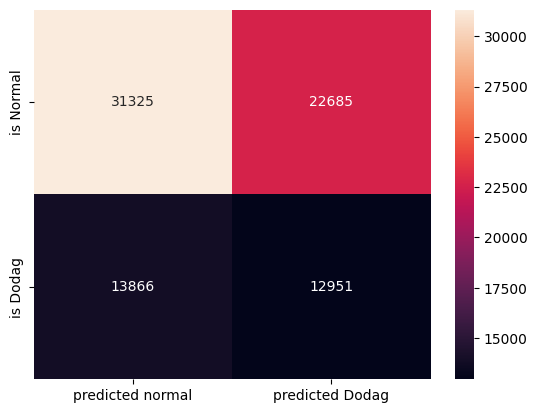

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

# Make predictions using the best model
y_predict =model_svc.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict, labels=[0, 1])

# Create DataFrame for confusion matrix
confusion = pd.DataFrame(conf_matrix, index=['is Normal', 'is Dodag'], columns=['predicted normal', 'predicted Dodag'])

# Visualize confusion matrix using heatmap
sns.heatmap(confusion, annot=True, fmt='d')

# Print classification report
print(classification_report(y_test, y_predict))


Correlation

In [14]:
import pandas as pd
import scipy.stats as stats

# Assuming your data is stored in a DataFrame called df
columns_of_interest = ['length', 'transmission_rate_per_1000_ms', 'reception_rate_per_1000_ms', 
                       'transmission_average_per_sec', 'reception_average_per_sec', 
                       'transmission_count_per_sec', 'reception_count_per_sec', 
                       'transmission_total_duration_per_sec', 'reception_total_duration_per_sec']

# Selecting only the numerical columns
numerical_data = df[columns_of_interest]

# Compute the Pearson correlation coefficient matrix
corr_matrix = numerical_data.corr()

# Display the correlation matrix
print(corr_matrix)


                                       length  transmission_rate_per_1000_ms  \
length                               1.000000                      -0.047827   
transmission_rate_per_1000_ms       -0.047827                       1.000000   
reception_rate_per_1000_ms          -0.402200                       0.208004   
transmission_average_per_sec        -0.020979                       0.915284   
reception_average_per_sec           -0.176993                       0.190788   
transmission_count_per_sec          -0.047968                       0.999996   
reception_count_per_sec             -0.402076                       0.208016   
transmission_total_duration_per_sec -0.030096                      -0.056208   
reception_total_duration_per_sec     0.229191                       0.082385   

                                     reception_rate_per_1000_ms  \
length                                                -0.402200   
transmission_rate_per_1000_ms                          0.208004  

In [15]:
# Compute the Spearman correlation coefficient matrix
spearman_corr_matrix = numerical_data.corr(method='spearman')

# Display the correlation matrix
print(spearman_corr_matrix)

                                       length  transmission_rate_per_1000_ms  \
length                               1.000000                      -0.052644   
transmission_rate_per_1000_ms       -0.052644                       1.000000   
reception_rate_per_1000_ms          -0.400716                       0.210013   
transmission_average_per_sec        -0.008138                       0.371044   
reception_average_per_sec           -0.037652                       0.110862   
transmission_count_per_sec          -0.052778                       0.999991   
reception_count_per_sec             -0.400786                       0.210012   
transmission_total_duration_per_sec -0.047333                      -0.090318   
reception_total_duration_per_sec     0.244001                       0.089155   

                                     reception_rate_per_1000_ms  \
length                                                -0.400716   
transmission_rate_per_1000_ms                          0.210013  

In [16]:

# Compute the Kendall tau correlation coefficient matrix
kendall_corr_matrix = numerical_data.corr(method='kendall')

# Display the correlation matrix
print(kendall_corr_matrix)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:5278: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


                                       length  transmission_rate_per_1000_ms  \
length                               1.000000                      -0.037643   
transmission_rate_per_1000_ms       -0.037643                       1.000000   
reception_rate_per_1000_ms          -0.318104                       0.157878   
transmission_average_per_sec        -0.006403                       0.162983   
reception_average_per_sec           -0.026558                       0.078665   
transmission_count_per_sec          -0.037710                       0.999552   
reception_count_per_sec             -0.318161                       0.157868   
transmission_total_duration_per_sec -0.035403                      -0.063617   
reception_total_duration_per_sec     0.182322                       0.062709   

                                     reception_rate_per_1000_ms  \
length                                                -0.318104   
transmission_rate_per_1000_ms                          0.157878  

In [17]:
import numpy as np

# Compute the correlation coefficient matrix
corr_matrix = np.corrcoef(numerical_data, rowvar=False)

# Display the correlation matrix
print(corr_matrix)

[[ 1.         -0.04782729 -0.40220007 -0.02097871 -0.17699275 -0.04796844
  -0.40207626 -0.03009616  0.2291912 ]
 [-0.04782729  1.          0.2080036   0.91528386  0.19078836  0.99999591
   0.20801615 -0.05620754  0.08238498]
 [-0.40220007  0.2080036   1.          0.17668165  0.89425606  0.20809688
   0.99999835 -0.0163375  -0.04784599]
 [-0.02097871  0.91528386  0.17668165  1.          0.19034908  0.91497759
   0.17669985  0.10634486  0.04155904]
 [-0.17699275  0.19078836  0.89425606  0.19034908  1.          0.19077809
   0.89425252  0.00785868  0.02671357]
 [-0.04796844  0.99999591  0.20809688  0.91497759  0.19077809  1.
   0.20811001 -0.0563362   0.08242156]
 [-0.40207626  0.20801615  0.99999835  0.17669985  0.89425252  0.20811001
   1.         -0.01632535 -0.04801673]
 [-0.03009616 -0.05620754 -0.0163375   0.10634486  0.00785868 -0.0563362
  -0.01632535  1.         -0.07934113]
 [ 0.2291912   0.08238498 -0.04784599  0.04155904  0.02671357  0.08242156
  -0.04801673 -0.07934113  1.  

In [18]:
import pandas as pd
corr_coefficient = df['length'].corr(df['transmission_rate_per_1000_ms'])
print("Correlation coefficient between column1 and column2:", corr_coefficient)


Correlation coefficient between column1 and column2: -0.0478272937304763


In [19]:
spearman_corr = df['length'].corr(df['transmission_rate_per_1000_ms'], method='spearman')

kendall_corr = df['length'].corr(df['transmission_rate_per_1000_ms'], method='kendall')

print("Spearman correlation coefficient:", spearman_corr)
print("Kendall correlation coefficient:", kendall_corr)

Spearman correlation coefficient: -0.05264399221765532
Kendall correlation coefficient: -0.037643183367722016


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:5278: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


In [20]:
# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

print(correlation_matrix)


                                         time    source  destination  \
time                                 1.000000  0.024451    -0.289278   
source                               0.024451  1.000000    -0.039107   
destination                         -0.289278 -0.039107     1.000000   
length                               0.195657 -0.047682     0.322843   
info                                -0.373450 -0.025129     0.945115   
transmission_rate_per_1000_ms       -0.161382 -0.373507     0.058259   
reception_rate_per_1000_ms          -0.245530 -0.028125    -0.090896   
transmission_average_per_sec        -0.050794 -0.223083    -0.002880   
reception_average_per_sec           -0.106827 -0.023256    -0.053301   
transmission_count_per_sec          -0.161668 -0.373757     0.058311   
reception_count_per_sec             -0.245468 -0.028132    -0.091103   
transmission_total_duration_per_sec  0.221662  0.045711    -0.216157   
reception_total_duration_per_sec    -0.190579 -0.039883     0.71

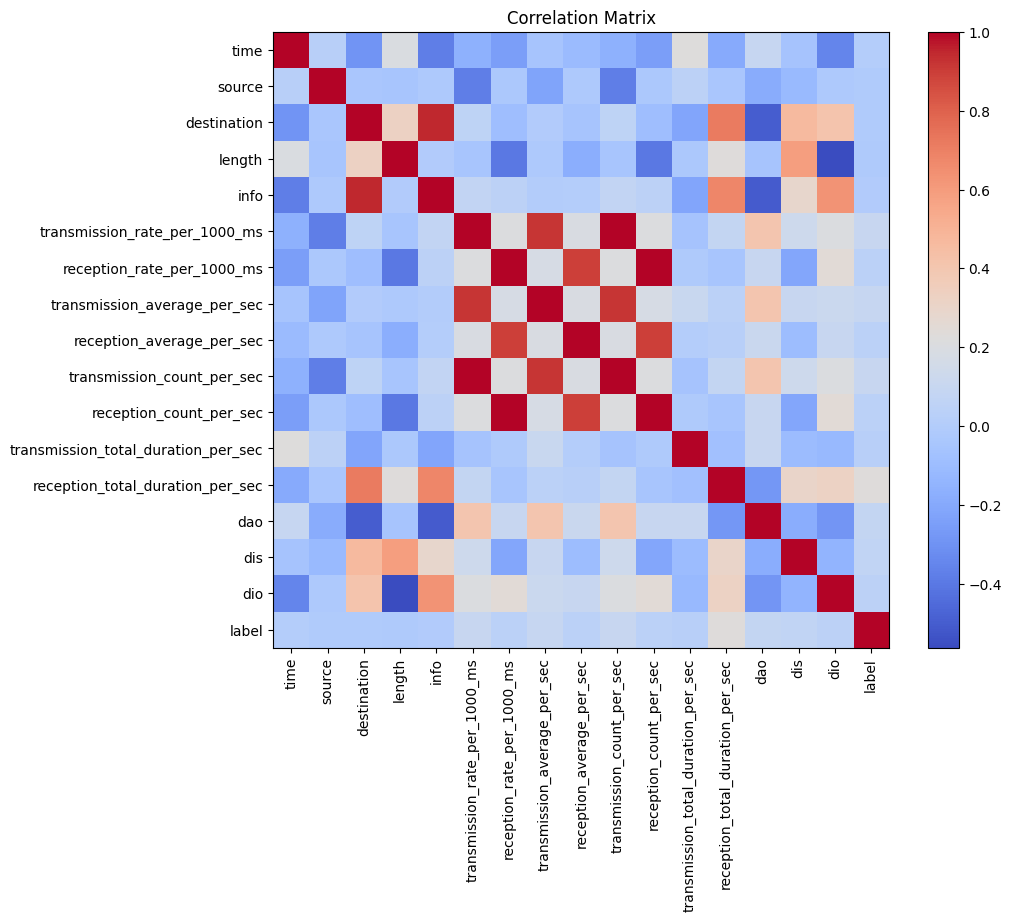

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix')
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()
